<a href="https://colab.research.google.com/github/nnilayy/Instance-Segmentation/blob/main/Instance_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check nvcc version
!nvcc --version
# Check GCC version
!gcc --version  
# Check graphics card version 
!nvidia-smi  

In [ ]:
import torch, torchvision
import mmdet
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print("Torch Version: ",torch.__version__) 
print("mmdet Verion: ",mmdet.__version__)
print("Is Cuda Available: ",torch.cuda.is_available()) 
print("Cuda Version: ",get_compiling_cuda_version())
print("GCC version: ",get_compiler_version())

##INSTALL MMCV AND MMDETECTION

In [ ]:
# install mmcv
!pip install openmim
!mim install mmcv-full

# install mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -e .

##DOWNLOADING THE DATASET

In [ ]:
# download and unzip the data
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
!unzip balloon_dataset.zip > /dev/null

In [ ]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('balloon/train/10464445726_6f1e3bbe6a_k.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

##DOWNLOAD MODEL WEIGHTS

In [ ]:
!mkdir /content/model_weights

link="https://download.openmmlab.com/mmdetection/v2.0/solov2/solov2_light_r18_fpn_3x_coco/solov2_light_r18_fpn_3x_coco_20220511_083717-75fa355b.pth"
model_name="solov2_light_r18_fpn_3x_coco_solov2_light_r18_fpn_3x_coco_20220511_083717-75fa355b"
file_name="/content/model_weights"

!wget -c "{link}" -O "{file_name}/{model_name}.pth"  

##CONVERTING DATASET TO COCO-JSON FORMAT

In [ ]:
import os.path as osp

def convert_balloon_to_coco(ann_file, out_file, image_prefix):
    data_infos = mmcv.load(ann_file)

    annotations = []
    images = []
    obj_count = 0
    for idx, v in enumerate(mmcv.track_iter_progress(data_infos.values())):
        filename = v['filename']
        img_path = osp.join(image_prefix, filename)
        height, width = mmcv.imread(img_path).shape[:2]

        images.append(dict(
            id=idx,
            file_name=filename,
            height=height,
            width=width))

        bboxes = []
        labels = []
        masks = []
        for _, obj in v['regions'].items():
            assert not obj['region_attributes']
            obj = obj['shape_attributes']
            px = obj['all_points_x']
            py = obj['all_points_y']
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            x_min, y_min, x_max, y_max = (
                min(px), min(py), max(px), max(py))


            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=0,
                bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                area=(x_max - x_min) * (y_max - y_min),
                segmentation=[poly],
                iscrowd=0)
            annotations.append(data_anno)
            obj_count += 1

    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=[{'id':0, 'name': 'balloon'}])
    mmcv.dump(coco_format_json, out_file)

In [ ]:
convert_balloon_to_coco(
    'balloon/train/via_region_data.json',
    'balloon/train/annotation_coco.json',
    'balloon/train/')
convert_balloon_to_coco(
    'balloon/val/via_region_data.json',
    'balloon/val/annotation_coco.json',
    'balloon/val/')

#TRAINING THE MODEL

##IMPORTING DEPENDENCIES

In [ ]:
from mmcv import Config
from mmdet.apis import set_random_seed
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.utils import get_device
from mmdet.apis import inference_detector, show_result_pyplot

##CHANGE THE CONFIG FILE 

* Get any model configs from this link: /content/mmdetection/configs


In [ ]:
config='/content/mmdetection/configs/solov2/solov2_light_r18_fpn_3x_coco.py'
cfg = Config.fromfile(config)
# USE THE MODEL FILES TO TRAIN BETTER AND QUICKER
cfg.load_from = "/content/logs_and_weights/epoch_10.pth"

# "/content/model_weights/solov2_light_r18_fpn_3x_coco_solov2_light_r18_fpn_3x_coco_20220511_083717-75fa355b.pth"
print(f'Config:\n{cfg.pretty_text}')

In [ ]:
#Change the number of classes in box head and mask head
# cfg.model.bbox_head.num_classes = 1
cfg.model.mask_head.num_classes = 1


# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10
cfg.evaluation.interval = 12
# Savepoint after mentioned intervals
cfg.checkpoint_config.interval = 10
cfg.runner.max_epochs=10
cfg.device=get_device()


# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]


# We can initialize the logger for training and have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

##DATASET AND CLASSES


In [ ]:
# Dataset-Type
cfg.dataset_type = 'COCODataset'

# Training Files and Annotations
cfg.data.train.ann_file = '/content/balls/train/train.json'
cfg.data.train.img_prefix = '/content/balls/train/images'
cfg.data.train.classes = ('Balls',)

# Testing Files and Annotations
cfg.data.test.ann_file = '/content/balls/val/val.json'
cfg.data.test.img_prefix = '/content/balls/val/images'
cfg.data.test.classes = ('Balls',)

# Validation Files and Annotations
cfg.data.val.ann_file = '/content/balls/val/val.json'
cfg.data.val.img_prefix = '/content/balls/val/images'
cfg.data.val.classes = ('Balls',)

# Build dataset
datasets = [build_dataset(cfg.data.train)]

## DIRECTORY FOR SAVING LOGS AND MODEL WEIGHTS

In [ ]:
!mkdir /content/logs_and_weights
cfg.work_dir = '/content/logs_and_weights'
# mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

mkdir: cannot create directory ‘/content/logs_and_weights’: File exists


##ASSIGNING THE MODEL THE CONIG FILE

In [ ]:
model = build_detector(cfg.model)
model.CLASSES = datasets[0].CLASSES

##FINALLY TRAINING THE MODEL

In [ ]:
train_detector(model, datasets, cfg, distributed=False, validate=True)

##TESTING THE MODEL

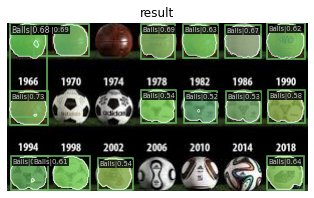

In [ ]:
# TESTING THE MODEL
link="/content/16.jpg"
img = mmcv.imread(link)
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result,score_thr=0.5)

##TENSORBOARD EVALUATIONS

In [ ]:
# LOAD TENSORBOARD AND SEE THE LOSS CURVES
%load_ext tensorboard
%tensorboard --logdir /content/logs_and_weights/tf_logs

#TESTING THE MODEL

In [ ]:
import mmcv
from mmcv.runner import load_checkpoint
from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector
from mmdet.utils import get_device

config = '/content/mmdetection/configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py'
cfg = mmcv.Config.fromfile(config)
model_weight= "/content/mmdetection/tutorial_exps/latest.pth"

# Setting up model
model = build_detector(cfg.model)
model_weight = load_checkpoint(model, model_weight, map_location=get_device())
model.CLASSES = model_weight['meta']['CLASSES']
model.cfg = cfg
model.to(get_device())
model.eval()

print(f'Config:\n{model_weight}')

In [ ]:
# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.0)